## Libraries

In [ ]:
!pip install python-louvain

# update python-louvain
!pip install --upgrade python-louvain

!pip install folium
# update folium
!pip install folium --upgrade
!pip install branca

In [1]:
# import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')

import matplotlib.cm as cm
import community as community_louvain
import networkx as nx
from networkx.algorithms.community import greedy_modularity_communities


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

pd.set_option('display.float_format', lambda x: '%.3f' % x)

## Preprocessing

In [3]:
df = pd.read_csv('trips.csv', index_col=0)

In [4]:
def check_df(df, head=5):
    print('########## SHAPE ##########')
    print(df.shape)
    print('########## INFO ##########')
    print(df.info())
    print('########## DESCRIBE ##########')
    print(df.describe().T)
    print('########## HEAD ##########')
    print(df.head(head))
    print('########## NA ##########')
    print(df.isnull().sum())

In [5]:
check_df(df)

########## SHAPE ##########
(1469851, 9)
########## INFO ##########
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1469851 entries, 1 to 1469851
Data columns (total 9 columns):
 #   Column             Non-Null Count    Dtype 
---  ------             --------------    ----- 
 0   Rental Id          1469851 non-null  int64 
 1   Duration           1469851 non-null  int64 
 2   Bike Id            1469851 non-null  int64 
 3   End Date           1469851 non-null  object
 4   EndStation Id      1469851 non-null  int64 
 5   EndStation Name    1469851 non-null  object
 6   Start Date         1469851 non-null  object
 7   StartStation Id    1469851 non-null  int64 
 8   StartStation Name  1469851 non-null  object
dtypes: int64(5), object(4)
memory usage: 112.1+ MB
None
########## DESCRIBE ##########
                      count         mean        std          min          25%  \
Rental Id       1469851.000 34967882.449 454261.085 34181580.000 34574455.500   
Duration        1469851.000    

In [18]:
def preprocessing(df, exclude_weekends: bool = True):
    # rename all columns that have spaces in them to have underscores instead

    df.columns = df.columns.str.replace(' ', '_')

    # convert the date column to datetime format

    df['Start_Date'] = pd.to_datetime(df['Start_Date'])
    df['End_Date'] = pd.to_datetime(df['End_Date'])

    df['Duration_MIN'] = (df['End_Date'] - df['Start_Date']).dt.total_seconds() / 60

    # set Rental_ID as index

    df.set_index('Rental_Id', inplace=True)

    # drops rows where it is a weekend

    if exclude_weekends:
        df = df[~df['Start_Date'].dt.day_name().isin(['Saturday', 'Sunday'])]
        df = df[~df['End_Date'].dt.day_name().isin(['Saturday', 'Sunday'])]   
        
    return df

In [ ]:
df = preprocessing(df, exclude_weekends=True)

In [8]:
# create a column that caclates the sum of all trips through the station in total, call it "Weights" as we will need it for our clustering

df['Weights_Start'] = df.groupby('StartStation_Id')['StartStation_Id'].transform('count')

# keep weight that are greater than 1

df = df[df['Weights_Start'] > 1]

df['Weights_End'] = df.groupby('EndStation_Id')['EndStation_Id'].transform('count')

# keep weight that are greater than 1

df = df[df['Weights_End'] > 1]

# create a column total weights

df['Total_Weights'] = df['Weights_Start'] + df['Weights_End']

In [9]:
df.head()

Duration  Bike_Id            End_Date  EndStation_Id  \
Rental_Id                                                         
34225975        300     5893 2014-06-23 00:05:00             70   
34225978        720     1245 2014-06-23 00:12:00            503   
34225979        600     5840 2014-06-23 00:10:00            723   
34225976        900     4358 2014-06-23 00:15:00            589   
34225977        900    12055 2014-06-23 00:15:00            589   

                         EndStation_Name Start_Date  StartStation_Id  \
Rental_Id                                                              
34225975   Calshot Street , King's Cross 2014-06-23               70   
34225978    Cleveland Way, Bethnal Green 2014-06-23              498   
34225979     Stephendale Road, Sands End 2014-06-23              680   
34225976        Drayton Gardens, Chelsea 2014-06-23              723   
34225977        Drayton Gardens, Chelsea 2014-06-23              723   

                       StartStation_Name  Duration_MIN  Weights_Start  \
Rental_Id                                                               
34225975   Calshot Street , King's Cross         5.000            877   
34225978           Bow Road Station, Bow        12.000           1004   
34225979      Westbridge Road, Battersea        10.000           1592   
34225976     Stephendale Road, Sands End        15.000           1521   
34225977     Stephendale Road, Sands End        15.000           1521   

           Weights_End  Total_Weights  
Rental_Id                              
34225975           833           1710  
34225978          1581           2585  
34225979          1540           3132  
34225976          1990           3511  
34225977          1990           3511

## EDA

In [10]:
df_EDA = df.copy()

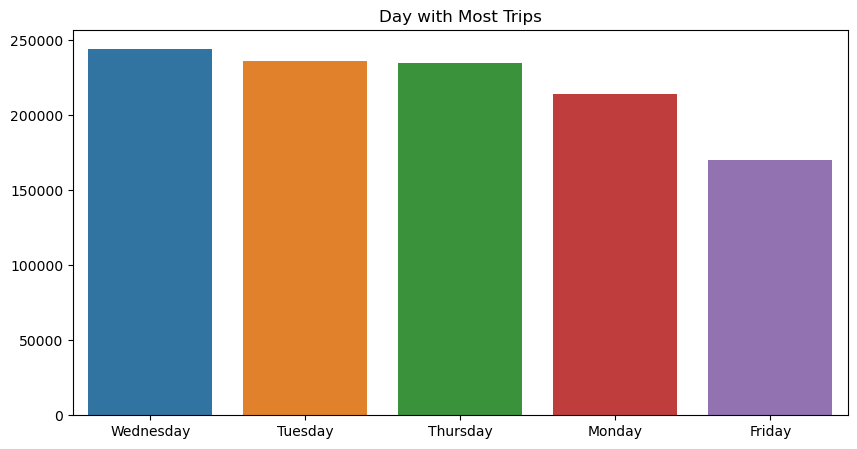

In [11]:
# get the week of day with most trips

plt.figure(figsize=(10, 5))
sns.barplot(x=df_EDA['Start_Date'].dt.day_name().value_counts().index, y=df_EDA['Start_Date'].dt.day_name().value_counts().values)
plt.title('Day with Most Trips')
plt.show()

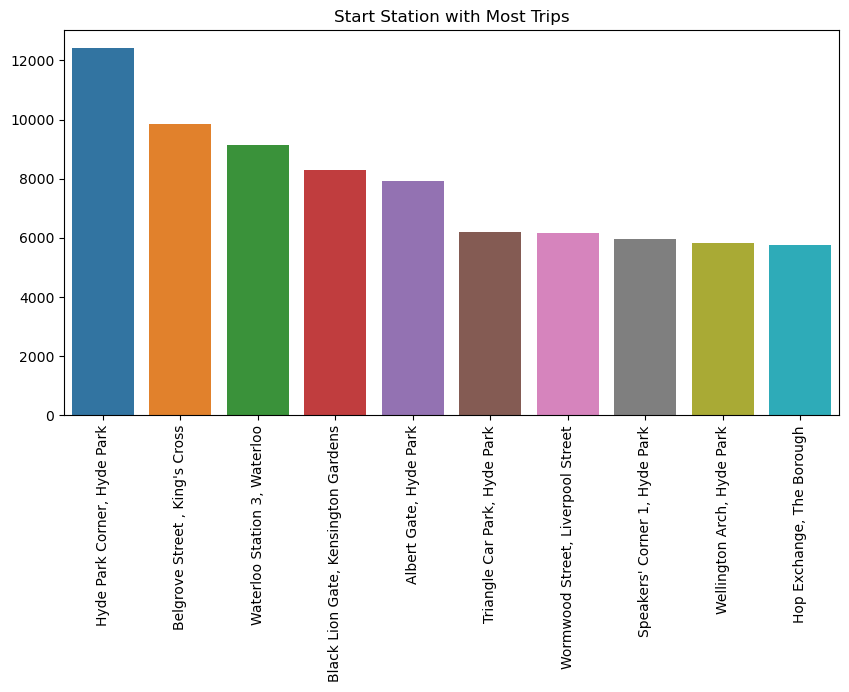

In [12]:
# create EDA plot for the start station

plt.figure(figsize=(10, 5))
sns.barplot(x=df_EDA['StartStation_Name'].value_counts().head(10).index, y=df_EDA['StartStation_Name'].value_counts().head(10).values)
plt.title('Start Station with Most Trips')
plt.xticks(rotation=90)
plt.show()

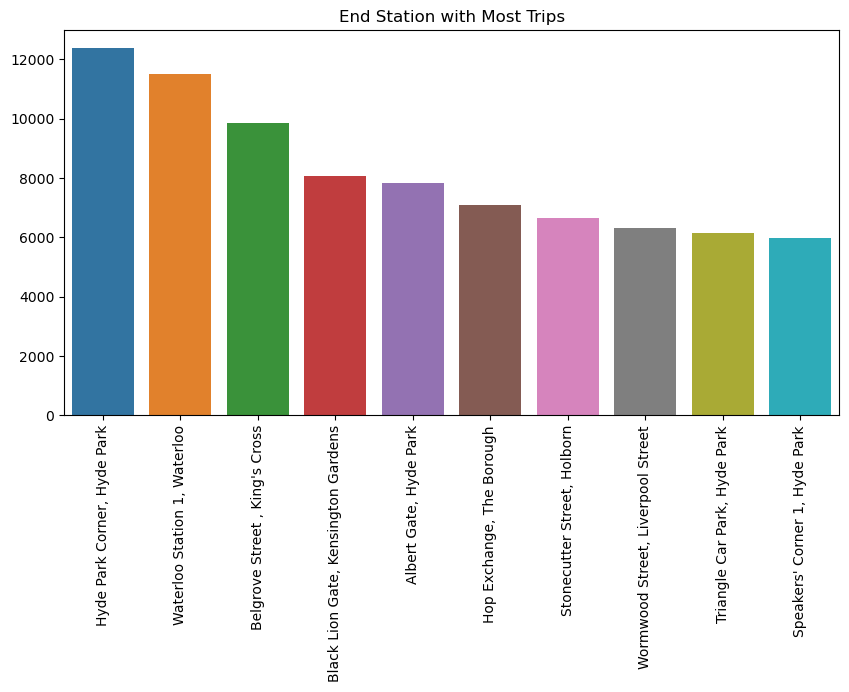

In [13]:
# create EDA plot for the start station

plt.figure(figsize=(10, 5))
sns.barplot(x=df_EDA['EndStation_Name'].value_counts().head(10).index, y=df_EDA['EndStation_Name'].value_counts().head(10).values)
plt.title('End Station with Most Trips')
plt.xticks(rotation=90)
plt.show()

In [14]:
# create a feature that is called "Sub_Borough" that is what comes after the first comma in StartStation_Name and EndStation_Name

df_EDA['StartStation_Sub_Borough'] = df_EDA['StartStation_Name'].str.split(',').str[1]
df_EDA['EndStation_Sub_Borough'] = df_EDA['EndStation_Name'].str.split(',').str[1]

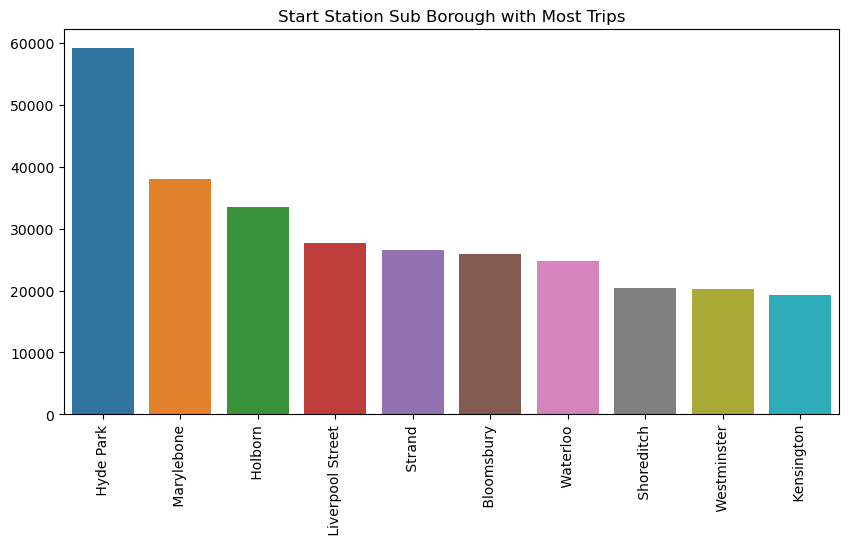

In [15]:
# create EDA plot for the start station sub borough 

plt.figure(figsize=(10, 5))
sns.barplot(x=df_EDA['StartStation_Sub_Borough'].value_counts().head(10).index, y=df_EDA['StartStation_Sub_Borough'].value_counts().head(10).values)
plt.title('Start Station Sub Borough with Most Trips')
plt.xticks(rotation=90)
plt.show()

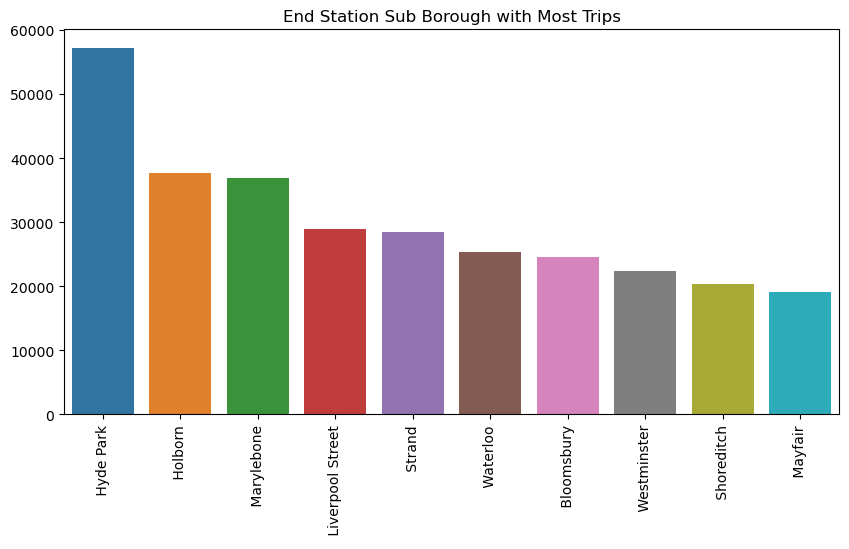

In [16]:
# create EDA plot for the end station sub borough

plt.figure(figsize=(10, 5))
sns.barplot(x=df_EDA['EndStation_Sub_Borough'].value_counts().head(10).index, y=df_EDA['EndStation_Sub_Borough'].value_counts().head(10).values)
plt.title('End Station Sub Borough with Most Trips')
plt.xticks(rotation=90)
plt.show()

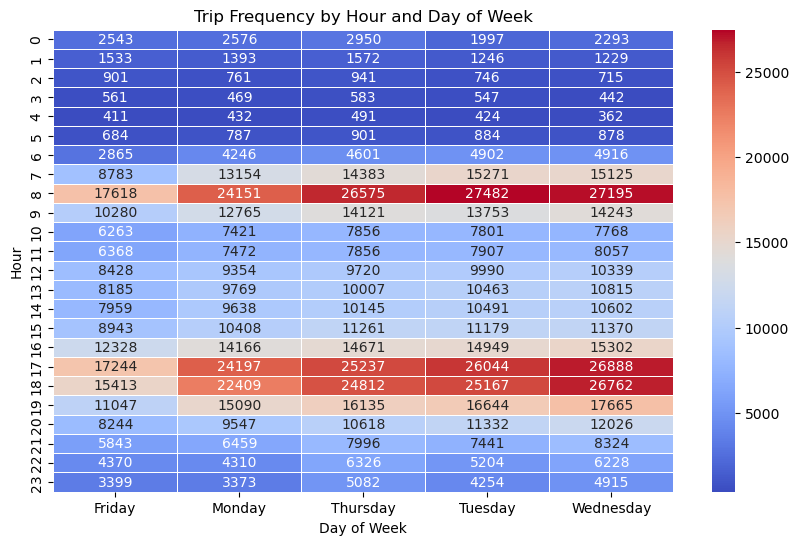

In [20]:
# Reset the index column to make Rental_Id a column again
df_EDA.reset_index(inplace=True)

# pivot table to get trip frequency by day of week and hour
trip_freq_by_hour = df_EDA.pivot_table(values='Rental_Id', index=df_EDA['Start_Date'].dt.hour, columns=df_EDA['Start_Date'].dt.day_name(), aggfunc='count')

# create heatmap
plt.figure(figsize=(10,6))
sns.heatmap(trip_freq_by_hour, linewidths=.5, annot=True, fmt='g', cmap= 'coolwarm')
plt.title('Trip Frequency by Hour and Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Hour')
plt.show()

## Louvain Clustering (Community Detection)

### First test

In [77]:
# create a new dataframe with start station ID, end station ID, and count of trips
edge_list = df.groupby(['StartStation_Id', 'EndStation_Id']).size().reset_index()
edge_list.columns = ['StartStation_Id', 'EndStation_Id', 'Weight']

# create graph from edge list dataframe
G = nx.from_pandas_edgelist(edge_list, 'StartStation_Id', 'EndStation_Id', 'Weight')

# calculate best partition using Louvain algorithm
partition_louvain = community_louvain.best_partition(G)

# create dataframe from partition
df_louvain = pd.DataFrame.from_dict(partition_louvain, orient='index')
df_louvain.columns = ['Community']
df_louvain.reset_index(inplace=True)
df_louvain.columns = ['Station', 'Community']

#plot graph with node colors based on community
plt.figure(figsize=(20,20))
colors = [cm.rainbow(float(i) / max(df_louvain.Community)) for i in df_louvain.Community]
nx.draw(G, node_color=colors, with_labels=True)
plt.show()


In [80]:
# create a new dataframe with start station ID, end station ID, and count of trips
edge_list = df.groupby(['StartStation_Id', 'EndStation_Id']).size().reset_index()
edge_list.columns = ['StartStation_Id', 'EndStation_Id', 'Weight']

# create graph from edge list dataframe
G = nx.from_pandas_edgelist(edge_list, 'StartStation_Id', 'EndStation_Id', 'Weight')

# create the partition using the greedy modularity algorithm
partition_greedy = greedy_modularity_communities(G, weight='Weight')

# create dataframe from the partition object
df_greedy = pd.DataFrame()
df_greedy['Community'] = 0
df_greedy['Station'] = 0
for i, community in enumerate(partition_greedy):
    for station in community:
        df_greedy.loc[station] = [i, station]

df_greedy.head()


Community  Station
1           0        1
3           0        3
4           0        4
9           0        9
10          0       10

In [53]:
df_dynamics_1 = df_greedy.copy()

In [ ]:
def louvain_clustering(df, plot_graph=True):
    """
    Perform Louvain clustering for community detection on a given graph.

    Parameters:
    -----------
    df : pandas.DataFrame
        A pandas DataFrame containing the graph data with 'StartStation_Id',
        'EndStation_Id', and 'Duration_MIN' columns.
    plot_graph : bool, default=True
        Whether to plot the graph with node colors based on communities.

    Returns:
    --------
    partition_df : pandas.DataFrame
        A pandas DataFrame containing the partition information with 'Station'
        and 'Community' columns.
    """

    # implment random seed

    np.random.seed(14)

    # Create an empty DataFrame to store the partition information
    partition_df = pd.DataFrame(columns=['Station', 'Community'])

    # Create a graph from the DataFrame
    G = nx.from_pandas_edgelist(df, source='StartStation_Id', target='EndStation_Id', edge_attr='Weighted_Edge')

    # Find the best partition using the Louvain algorithm
    partition = community_louvain.best_partition(G)

    print(partition)

    # Add the partition information to the DataFrame
    partition_df['Station'] = partition.keys()
    partition_df['Community'] = partition.values()

    # Indicate the proportion of nodes in each community
    community_ratio = partition_df['Community'].value_counts(normalize=True)
    print(f'The proportion of nodes in each community is:\n{community_ratio}')

    print('------------------------------------')

    
    # print the modularity score

    modularity_score = community_louvain.modularity(partition, G)

    print(f'The modularity score is : {modularity_score}')

    print('------------------------------------')


    # Create a list of colors for the communities
    colors = [cm.rainbow(float(i) / max(partition_df['Community'])) for i in partition_df['Community']]


    # node size

    node_size = [G.degree(node) * 2 for node in G.nodes()] 

    # Plot the graph with node colors based on communities

    if plot_graph:
            #pos = nx.spring_layout(G)
            plt.figure(figsize=(20, 10))
            nx.draw(G, node_color=colors, with_labels=True, alpha=0.8, width=0.2)
            #nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color=colors)
            #nx.draw_networkx_labels(G, pos, font_size=8)
            #plt.axis('off')
            plt.show()

    return partition_df

In [ ]:
# used in TP5
def GetInfoGraph(G):
    print('number of edges', G.number_of_edges())
    print('number of nodes', G.number_of_nodes())
    print('min degree', np.min([degree[1] for degree in G.degree()])) # minimum degree
    print('max degree', np.max([degree[1] for degree in G.degree()]))# maximum degree
    #print('VERTICES', G.nodes())
    #print('EDGES', G.edges())
    print('Is connected ?', nx.is_connected(G))
    print('number of connected components: ', nx.number_connected_components(G))
    nx.draw(G, with_labels =True)

In [ ]:
G = nx.from_pandas_edgelist(df, source='StartStation_Id', target='EndStation_Id', edge_attr='Weighted_Edge')

GetInfoGraph(G)

In [ ]:
df_louvain = louvain_clustering(df, plot_graph=True)

In [ ]:
def compute_modularity(G, partition):
    '''
    :param G: given graph
    :param partition: a tuple of node sets.
    :return result: modularity value for a given partition of the network.
    '''    
    num_of_edges = G.number_of_edges()
    modularity_list = []
    
    # Loop over communities
    for subset in partition:
        nodelist = list(subset)
        G_subset = G.subgraph(nodelist)
        A = nx.adj_matrix(G_subset)
        
        s = 0
        # For all pair of nodes inside these communities
        for i in range(G_subset.number_of_nodes()):
            for j in range(G_subset.number_of_nodes()):
                s += A[i, j] - ( ( nx.degree(G, nodelist[i])*nx.degree(G, nodelist[j]) ) / (2.0*num_of_edges) )
            
        modularity_list.append(s / (2.0*num_of_edges))
            
    return np.sum(modularity_list)

## PLOTS LONDON

In [64]:
import folium
import pandas as pd
import folium.plugins

import branca
import branca.colormap as cm

def plot_map(df):
    # Read the stations.csv file and create a dataframe called df_stations
    df_stations = pd.read_csv('stations.csv')

    # rename the id column to Station
    df_stations.rename(columns={'id': 'Station'}, inplace=True)

    # merge the two dataframes on the Station column
    df_merged = df.merge(df_stations[['Station', 'lat', 'long']], on='Station', how='left')

    # create a map of the stations
    df_merged.dropna(inplace=True)

    # Sort the dataframe by Community
    df_merged.sort_values(by='Community', inplace=True)

    # create a map of the stations
    x_start = (df_merged['lat'].max() + df_merged['lat'].min()) / 2
    y_start = (df_merged['long'].max() + df_merged['long'].min()) / 2
    start_coord = (x_start, y_start)

    n_colors = df_merged.Community.nunique()

    if n_colors <= 4:
        colormap = cm.LinearColormap(colors=['red', 'orange', 'green','blue'], vmin=0, vmax=n_colors - 1, caption='Community')
    elif n_colors == 5:
        colormap = cm.LinearColormap(colors=['orange', 'blue', 'green','red', 'purple'], vmin=0, vmax=n_colors - 1, caption='Community')
    elif n_colors == 6:
        colormap = cm.LinearColormap(colors=['orange', 'blue', 'green','red', 'purple'], vmin=0, vmax=n_colors - 1, caption='Community')

    map = folium.Map(location=start_coord, zoom_start=12)


    lat = list(df_merged.lat)
    lon = list(df_merged.long)
    com = list(df_merged.Community)


    for loc, p in zip(zip(lat, lon), com):
        folium.Circle(
            location=loc,
            radius=75,
            fill=True,
            color=colormap(p),
            #fill_opacity=0.7
        ).add_to(map)

    map.add_child(colormap)

    display(map)

   

In [16]:
plot_map(df_louvain)

In [17]:
plot_map(df_greedy)

In [68]:
# Plot the Infomap and Walktrap communities on the map
communities = pd.read_csv('communities_r.csv', index_col=0)

def plot_from_r(algo):
    df_algo = communities[['id', algo]]
    df_algo.columns = ['Station', 'Community']
    df_algo.Community = df_algo.Community - 1
    plot_map(df_algo)
    return df_algo


In [69]:
algos = ['infomap', 'walks']

for algo in algos:
    plot_from_r(algo)
    

In [71]:
df_algo = plot_from_r('infomap')

In [72]:
df_algo.Community.value_counts()

0    478
1    190
3     35
2     27
4     20
Name: Community, dtype: int64

## Community Evolution

In [54]:
# read the 8 documents into a merged dataframe from 'extract1.csv' to 'extract8.csv'
df = pd.read_csv('extract1.csv')
for i in range(2,9):
    df = df.append(pd.read_csv('extract' + str(i) + '.csv'))

df.head()



Rental Id  Duration  Bike Id          End Date  EndStation Id  \
0  120934794       300    18470  04/06/2022 10:15         30.000   
1  120948759      1320    11870  04/06/2022 16:11        157.000   
2  120972867       300    10649  05/06/2022 12:34        289.000   
3  120857309       840    11393  02/06/2022 13:19        624.000   
4  120848312       960    10138  02/06/2022 09:55        624.000   

                   EndStation Name        Start Date  StartStation Id  \
0          Windsor Terrace, Hoxton  04/06/2022 10:10               52   
1        Wright's Lane, Kensington  04/06/2022 15:49              349   
2     South Audley Street, Mayfair  05/06/2022 12:29              116   
3  Courland Grove, Wandsworth Road  02/06/2022 13:05              624   
4  Courland Grove, Wandsworth Road  02/06/2022 09:39              624   

                 StartStation Name  
0        Roscoe Street, St. Luke's  
1       St. George Street, Mayfair  
2   Little Argyll Street, West End  
3  Courland Grove, Wandsworth Road  
4  Courland Grove, Wandsworth Road

In [21]:
check_df(df)

########## SHAPE ##########
(2370939, 9)
########## INFO ##########
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2370939 entries, 0 to 283363
Data columns (total 9 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Rental Id          int64  
 1   Duration           int64  
 2   Bike Id            int64  
 3   End Date           object 
 4   EndStation Id      float64
 5   EndStation Name    object 
 6   Start Date         object 
 7   StartStation Id    int64  
 8   StartStation Name  object 
dtypes: float64(1), int64(4), object(4)
memory usage: 180.9+ MB
None
########## DESCRIBE ##########
                      count          mean        std           min  \
Rental Id       2370939.000 122022454.062 703204.587 120804357.000   
Duration        2370939.000      1316.558   4210.673        60.000   
Bike Id         2370939.000     15805.730   5940.910         1.000   
EndStation Id   2058795.000       393.005    245.833         1.000   
StartStation Id 237

In [55]:
# create a column that caclates the sum of all trips through the station in total, call it "Weights" as we will need it for our clustering

df['Weights_Start'] = df.groupby('StartStation Id')['StartStation Id'].transform('count')

# keep weight that are greater than 1

df = df[df['Weights_Start'] > 1]

df['Weights_End'] = df.groupby('EndStation Id')['EndStation Id'].transform('count')

# keep weight that are greater than 1

df = df[df['Weights_End'] > 1]

# create a column total weights

df['Total_Weights'] = df['Weights_Start'] + df['Weights_End']

In [23]:
df.head()

Rental Id  Duration  Bike Id          End Date  EndStation Id  \
0  120934794       300    18470  04/06/2022 10:15         30.000   
1  120948759      1320    11870  04/06/2022 16:11        157.000   
2  120972867       300    10649  05/06/2022 12:34        289.000   
3  120857309       840    11393  02/06/2022 13:19        624.000   
4  120848312       960    10138  02/06/2022 09:55        624.000   

                   EndStation Name        Start Date  StartStation Id  \
0          Windsor Terrace, Hoxton  04/06/2022 10:10               52   
1        Wright's Lane, Kensington  04/06/2022 15:49              349   
2     South Audley Street, Mayfair  05/06/2022 12:29              116   
3  Courland Grove, Wandsworth Road  02/06/2022 13:05              624   
4  Courland Grove, Wandsworth Road  02/06/2022 09:39              624   

                 StartStation Name  Weights_Start  Weights_End  Total_Weights  
0        Roscoe Street, St. Luke's           2357     1574.000       3931.000  
1       St. George Street, Mayfair           2881     4036.000       6917.000  
2   Little Argyll Street, West End           8874     1454.000      10328.000  
3  Courland Grove, Wandsworth Road           2265     2022.000       4287.000  
4  Courland Grove, Wandsworth Road           2265     2022.000       4287.000

In [40]:
# create a new dataframe with start station ID, end station ID, and count of trips
edge_list = df.groupby(['StartStation Id', 'EndStation Id']).size().reset_index()
edge_list.columns = ['StartStation Id', 'EndStation Id', 'Weight']

# create graph from edge list dataframe
G = nx.from_pandas_edgelist(edge_list, 'StartStation Id', 'EndStation Id', 'Weight')

# calculate best partition using Louvain algorithm
partition = community_louvain.best_partition(G)

# create dataframe from partition
df_louvain = pd.DataFrame.from_dict(partition, orient='index')
df_louvain.columns = ['Community']
df_louvain.reset_index(inplace=True)
df_louvain.columns = ['Station', 'Community']

In [56]:
# create a new dataframe with start station ID, end station ID, and count of trips
edge_list = df.groupby(['StartStation Id', 'EndStation Id']).size().reset_index()
edge_list.columns = ['StartStation Id', 'EndStation Id', 'Weight']

# create graph from edge list dataframe
G = nx.from_pandas_edgelist(edge_list, 'StartStation Id', 'EndStation Id', 'Weight')

# create the partition using the greedy modularity algorithm
partition = greedy_modularity_communities(G, weight='Weight')

# create dataframe from the partition object
df_greedy = pd.DataFrame()
df_greedy['Community'] = 0
df_greedy['Station'] = 0
for i, community in enumerate(partition):
    for station in community:
        df_greedy.loc[station] = [i, station]

In [46]:
dfs = [df_louvain, df_greedy]

for df in dfs:
    plot_map(df)

In [ ]:
# Community dynamics analysis between 2014 and 2022 with the greedy algorithm

df_dynamics_2 = df_greedy.copy()

# add a year column equal to 2014 to the first dataframe
df_dynamics_1['Year'] = 2014

# add a year column equal to 2022 to the second dataframe
df_dynamics_2['Year'] = 2022

# combine the two dataframes
df_dynamics = df_dynamics_1.append(df_dynamics_2)

# create a pivot table with the community as the index, the year as the columns, and the number of stations in each community as the values
df_pivot = pd.pivot_table(df_dynamics, index='Community', columns='Year', values='Station', aggfunc='count')

# fill the NaN values with 0
df_pivot.fillna(0, inplace=True)

# create a new column that calculates the change in community size between 2014 and 2022
df_pivot['Change'] = df_pivot[2022] - df_pivot[2014]

# sort the dataframe by the change column
df_pivot.sort_values(by='Change', inplace=True)






<AxesSubplot:xlabel='Community'>

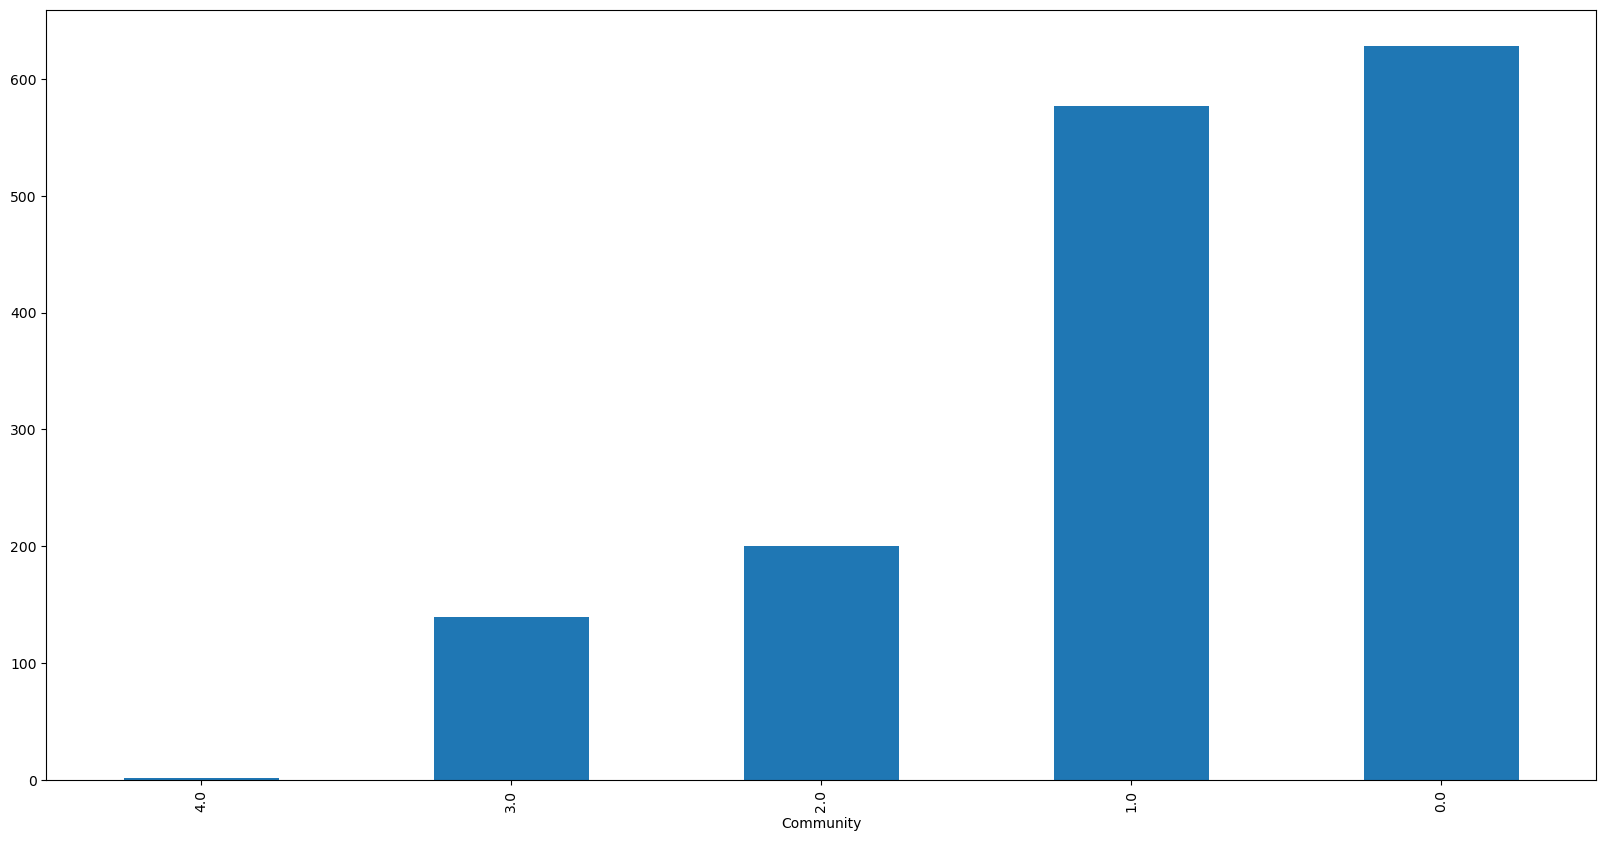

In [60]:
# create a new dataframe with the community as the index and the number of stations in each community as the values
df_stations = df_dynamics.groupby('Community').count()

# sort the dataframe by the number of stations in each community
df_stations.sort_values(by='Station', inplace=True)

# create a bar chart of the number of stations in each community
df_stations['Station'].plot(kind='bar', figsize=(20,10))

<AxesSubplot:xlabel='Community'>

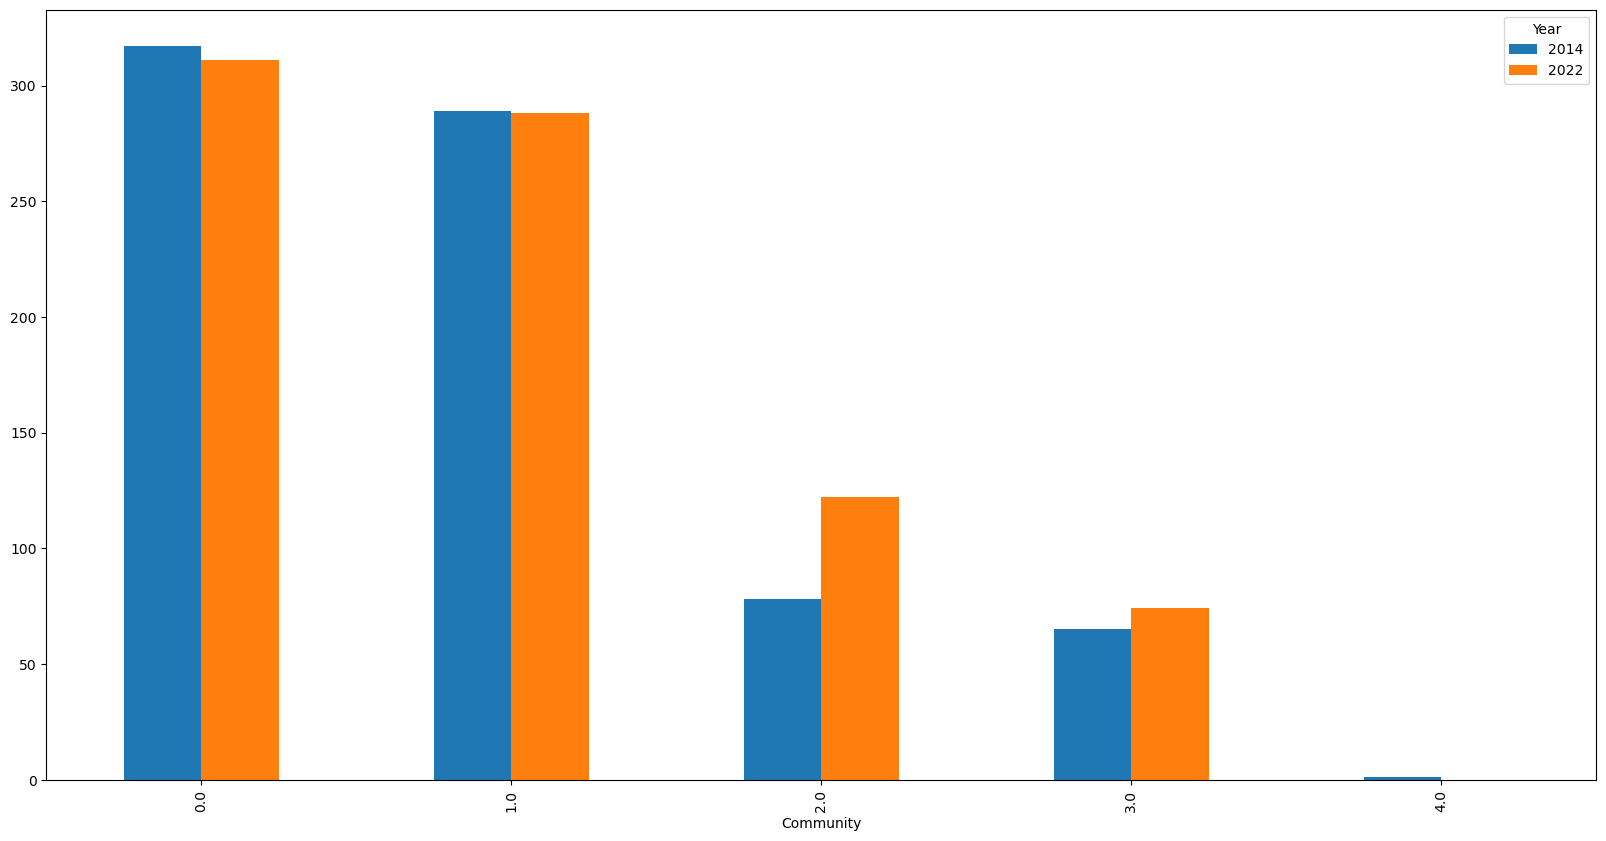

In [63]:
# create a plot to show the flow of trips between communities
df_dynamics.groupby(['Community', 'Year']).count()['Station'].unstack().plot(kind='bar', figsize=(20,10))




In [98]:

df_pivot

Year         2014    2022  Change
Community                        
0.000     317.000 311.000  -6.000
1.000     289.000 288.000  -1.000
4.000       1.000   0.000  -1.000
3.000      65.000  74.000   9.000
2.000      78.000 122.000  44.000